# Copyright Netherlands eScience Center <br>
**Function     : Review Fig - BayesianLSTM forecasts and the state-dependency of errors** <br>
**Author       : Yang Liu** <br>
**First Built  : 2021.04.28** <br>
**Last Update  : 2021.05.08** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to make figures for the paper.<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
#import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("H:\\Creator_Zone\\Script_craft\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79


Bad key text.latex.unicode in file G:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file G:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file G:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.temp

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# model type
model_type = 'lorenz84ex' # choose lorenz84 / lorenz84ex / lorenz84AA
# datapath for output
output_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\paperFig\\review'
# data path of experiment
#pred_lorenz_bayesconvlstm_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100'
#pred_lorenz_bayesconvlstm_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\longLeadTime'
#pred_lorenz_bayesconvlstm_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100000_stdx4'
pred_lorenz_bayesconvlstm_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100000_stdx4_layer3'

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
original model<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
with periodic forcing<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>
with AA effect<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4, alpha = 0.025, beta = 0.00625** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.25010 : 0.24990] **~0.04%**<br>
a_ex = [0.250010 : 0.249990] **~0.004%**<br>
a_ex = [0.2500010 : 0.2499990] **~0.0004%**<br>
========================================================================================================<br>

In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 0.4):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

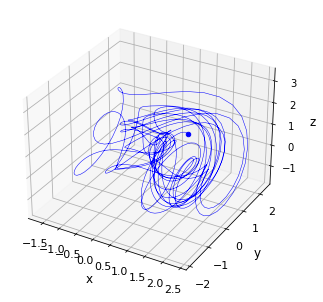

<Figure size 432x288 with 0 Axes>

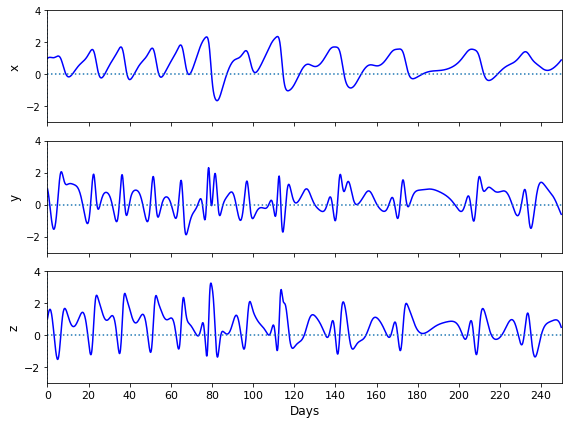

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(6.5,4.2))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, 'b', lw=0.5)
    ax.scatter3D(x[0], y[0], z[0], color = 'b')
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_zlabel("z", fontsize=12)
    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    #ax.set_title("Lorenz-84 model")
    plt.tight_layout()
    plt.show()
    #fig00.savefig(os.path.join(output_path, 'lorenz84_trajectory'),dpi=150) 
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(8, 6, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'b', label='y')
    ax3.plot(index, z, 'b', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 4)
    ax2.set_ylim(-3, 4)
    ax3.set_ylim(-3, 4)
    
    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xlabel("Days", fontsize=12)
    
    plt.xticks(np.arange(0,num_steps+1,120),np.arange(0,num_steps//6+1,20),fontsize=11)
    plt.yticks(fontsize=11)
    
    #ax1.legend()
    #ax2.legend()
    #ax3.legend()
    
    plt.tight_layout()
    plt.show()
    #fig01.savefig(os.path.join(output_path, 'lorenz84_series'),dpi=150) 

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std
    x_std = np.std(x[-test_len:])
    y_std = np.std(y[-test_len:])
    z_std = np.std(z[-test_len:])
    
    x_std_full = np.std(x[:])
    y_std_full = np.std(y[:])
    z_std_full = np.std(z[:])

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


# Postprocess forecast data <br>
** Postprocess and visualization of ensemble forecast data ** <br>

In [9]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 60 # unit week
    # number of ensembles
    ens = 20
    predictand = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        #dataset_pred = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path,'pred_lorenz84_epoch3000_p100000_stdx4_ens_{}.nc'.format(i)))
        dataset_pred = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path,'pred_lorenz84_epoch3000_p100000_stdx4_layer3_ens_{}.nc'.format(i)))        
        #predictand[i,:,:,:] = dataset_pred.variables['series'][:]
        predictand[i,:,:,:] = dataset_pred.variables['series'][:,:,:step_lead]
    print(predictand.shape)
    predictand_median = np.median(predictand, 0)
    
    # adding root for plotting
    predictand_root = np.zeros((ens, 3, test_len, step_lead+1), dtype=float)
    predictand_root[:,0,:,0] = np.repeat(x_norm[np.newaxis,-test_len-1:-1],ens,0)
    predictand_root[:,1,:,0] = np.repeat(y_norm[np.newaxis,-test_len-1:-1],ens,0)
    predictand_root[:,2,:,0] = np.repeat(z_norm[np.newaxis,-test_len-1:-1],ens,0)
    predictand_root[:,:,:,1:] = predictand[:]
    
    predictand_median_root = np.zeros((3, test_len, step_lead+1), dtype=float)
    predictand_median_root[0,:,0] = x_norm[-test_len-1:-1]
    predictand_median_root[1,:,0] = y_norm[-test_len-1:-1]
    predictand_median_root[2,:,0] = z_norm[-test_len-1:-1]
    predictand_median_root[:,:,1:] = predictand_median[:]    

*******************  load ensemble data  *********************
(20, 3, 200, 60)


In [10]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [11]:
    ###################################################################################
    ########                       compute the errors                          ########
    ###################################################################################
    # compute the error between forecast median and Lorenz model
    predictand_median_error = np.zeros(predictand_median.shape, dtype=float)
    for i in range(step_lead):
        predictand_median_error[0,:,i] = (predictand_median[0,:,i] * (x_max - x_min) + x_min)\
                                         - xx[-(test_len + step_lead)+i:-step_lead+i]
        predictand_median_error[1,:,i] = (predictand_median[1,:,i] * (y_max - y_min) + y_min)\
                                         - yy[-(test_len + step_lead)+i:-step_lead+i]
        predictand_median_error[2,:,i] = (predictand_median[2,:,i] * (z_max - z_min) + z_min)\
                                         - zz[-(test_len + step_lead)+i:-step_lead+i]
    
    #print(predictand_median_error[0,:3,:10])
    # shuffle the error
    # reshuffle a multi-dimension array with numpy.random.shuffle
    # This function only shuffles the array along the first axis of a multi-dimensional array.
    # The order of sub-arrays is changed but their contents remains the same.
    np.random.shuffle(predictand_median_error[0,:,:])
    np.random.shuffle(predictand_median_error[1,:,:])
    np.random.shuffle(predictand_median_error[2,:,:])
    #print(predictand_median_error[0,:3,:10])
    # adding root for plotting
    predictand_median_error_root = np.zeros((3, test_len, step_lead+1), dtype=float)
    predictand_median_error_root[:,:,0] = 0
    predictand_median_error_root[:,:,1:] = predictand_median_error[:]

===================  visualize data  =====================
===================    time series   =====================


<Figure size 432x288 with 0 Axes>

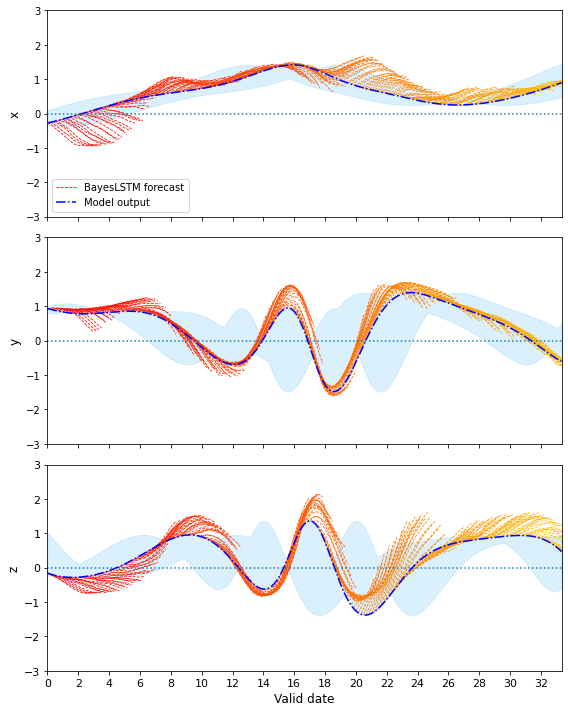

In [12]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - timeseries   ########
    ###################################################################################
    index_lead = np.arange(test_len+step_lead+1)
    print ('===================  visualize data  =====================')
    print ('===================    time series   =====================')
    # target lead steps 6, 18, 42, 60
    colormap1=cm.autumn(range(test_len))
    #colormap2=cm.spring(range(test_len))
    colormap2=cm.autumn(range(test_len))
    
    display_upto = 18
    
    fig02 = plt.figure()
    fig02, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig02.set_size_inches(8, 10, forward=True)
    
    # autocorrelation band by moving the series
    # move time lag
    lag_move = 18 # steps
    
    x_band_range = np.zeros((3,test_len+1),dtype=float)
    y_band_range = np.zeros((3,test_len+1),dtype=float)
    z_band_range = np.zeros((3,test_len+1),dtype=float)
    
    x_band_range[0,:] = xx[num_steps-test_len-1+lag_move:num_steps+lag_move] # move backward
    x_band_range[1,:] = x[-test_len-1:] # obs
    x_band_range[2,:] = x[-test_len-1-lag_move:-lag_move] # move forward
    
    y_band_range[0,:] = yy[num_steps-test_len-1+lag_move:num_steps+lag_move] # move backward
    y_band_range[1,:] = y[-test_len-1:] # obs
    y_band_range[2,:] = y[-test_len-1-lag_move:-lag_move] # move forward
    
    z_band_range[0,:] = zz[num_steps-test_len-1+lag_move:num_steps+lag_move] # move backward
    z_band_range[1,:] = z[-test_len-1:] # obs
    z_band_range[2,:] = z[-test_len-1-lag_move:-lag_move] # move forward
    
    # compute the band
    x_band_max = np.amax(x_band_range,0)
    x_band_min = np.amin(x_band_range,0)
    y_band_max = np.amax(y_band_range,0)
    y_band_min = np.amin(y_band_range,0)
    z_band_max = np.amax(z_band_range,0)
    z_band_min = np.amin(z_band_range,0)
    
    # plot the band
    ax1.fill_between(index[:test_len+1], x_band_max, x_band_min,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index[:test_len+1], y_band_max, y_band_min,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index[:test_len+1], z_band_max, z_band_min,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    # BayesLSTM
    for i in range(test_len):
        if i == 0:
            ax1.plot(index[i:i+display_upto+1], predictand_root[4, 0, i, :display_upto+1] * (x_max - x_min) + x_min,
                     color=colormap1[i], linestyle='dashed', linewidth = 0.8, label="BayesLSTM forecast")
        else:
            ax1.plot(index[i:i+display_upto+1], predictand_root[4, 0, i, :display_upto+1] * (x_max - x_min) + x_min,
                     color=colormap1[i], linestyle='dashed', linewidth = 0.8)            
        ax2.plot(index[i:i+display_upto+1], predictand_root[4, 1, i, :display_upto+1] * (y_max - y_min) + y_min,
                 color=colormap1[i], linestyle='dashed', linewidth = 0.8)
        ax3.plot(index[i:i+display_upto+1], predictand_root[4, 2, i, :display_upto+1] * (z_max - z_min) + z_min,
                 color=colormap1[i], linestyle='dashed', linewidth = 0.8)
    # obs
    ax1.plot(index[:test_len+1], x[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax2.plot(index[:test_len+1], y[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax3.plot(index[:test_len+1], z[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')

    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=1)
    #ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xlabel("Valid date", fontsize=12)
    
    plt.xticks(np.arange(0,test_len+1,12),np.arange(0,test_len//6+1,2),fontsize=11)
    plt.yticks(fontsize=11)
    
    plt.tight_layout()

    plt.show()
    fig02.savefig(os.path.join(output_path,'BayesLSTM_forecast_lorenz84_series_onlyOne_leadTime{}.png'.format(display_upto)),dpi=150) 

===================  visualize data  =====================
===================    time series   =====================


<Figure size 432x288 with 0 Axes>

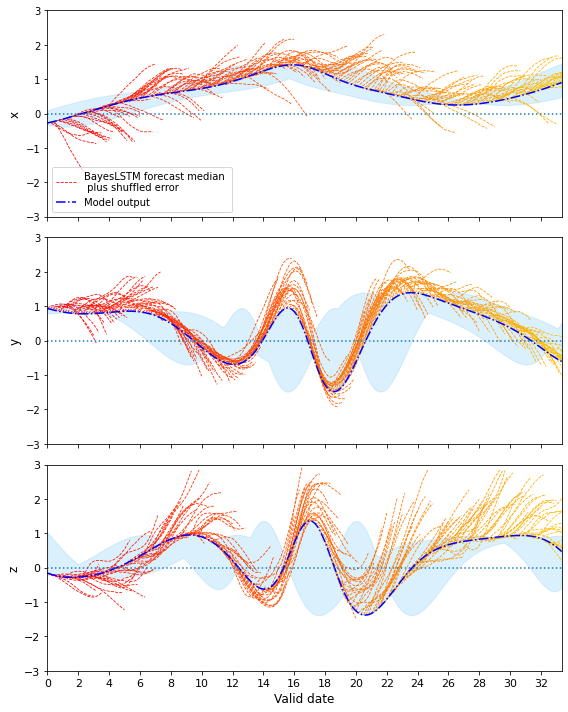

In [13]:
    print ('===================  visualize data  =====================')
    print ('===================    time series   =====================')  
    fig22 = plt.figure()
    fig22, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig22.set_size_inches(8, 10, forward=True)
    
    # autocorrelation band by moving the series
    # move time lag
    lag_move = 18 # steps
    
    x_band_range = np.zeros((3,test_len+1),dtype=float)
    y_band_range = np.zeros((3,test_len+1),dtype=float)
    z_band_range = np.zeros((3,test_len+1),dtype=float)
    
    x_band_range[0,:] = xx[num_steps-test_len-1+lag_move:num_steps+lag_move] # move backward
    x_band_range[1,:] = x[-test_len-1:] # obs
    x_band_range[2,:] = x[-test_len-1-lag_move:-lag_move] # move forward
    
    y_band_range[0,:] = yy[num_steps-test_len-1+lag_move:num_steps+lag_move] # move backward
    y_band_range[1,:] = y[-test_len-1:] # obs
    y_band_range[2,:] = y[-test_len-1-lag_move:-lag_move] # move forward
    
    z_band_range[0,:] = zz[num_steps-test_len-1+lag_move:num_steps+lag_move] # move backward
    z_band_range[1,:] = z[-test_len-1:] # obs
    z_band_range[2,:] = z[-test_len-1-lag_move:-lag_move] # move forward
    
    # compute the band
    x_band_max = np.amax(x_band_range,0)
    x_band_min = np.amin(x_band_range,0)
    y_band_max = np.amax(y_band_range,0)
    y_band_min = np.amin(y_band_range,0)
    z_band_max = np.amax(z_band_range,0)
    z_band_min = np.amin(z_band_range,0)
    
    # plot the band
    ax1.fill_between(index[:test_len+1], x_band_max, x_band_min,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index[:test_len+1], y_band_max, y_band_min,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index[:test_len+1], z_band_max, z_band_min,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    # BayesLSTM
    for i in range(test_len):
        if i == 0:
            ax1.plot(index[i:i+display_upto+1], predictand_median_root[0, i, :display_upto+1] * (x_max - x_min) + x_min + predictand_median_error_root[0, i, :display_upto+1],
                     color=colormap2[i], linestyle='dashed', linewidth = 0.8, label="BayesLSTM forecast median \n plus shuffled error")
        else:
            ax1.plot(index[i:i+display_upto+1], predictand_median_root[0, i, :display_upto+1] * (x_max - x_min) + x_min + predictand_median_error_root[0, i, :display_upto+1],
                     color=colormap2[i], linestyle='dashed', linewidth = 0.8)            
        ax2.plot(index[i:i+display_upto+1], predictand_median_root[1, i, :display_upto+1] * (y_max - y_min) + y_min + predictand_median_error_root[1, i, :display_upto+1],
                 color=colormap2[i], linestyle='dashed', linewidth = 0.8)
        ax3.plot(index[i:i+display_upto+1], predictand_median_root[2, i, :display_upto+1] * (z_max - z_min) + z_min + predictand_median_error_root[2, i, :display_upto+1],
                 color=colormap2[i], linestyle='dashed', linewidth = 0.8)
    # obs
    ax1.plot(index[:test_len+1], x[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax2.plot(index[:test_len+1], y[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax3.plot(index[:test_len+1], z[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')

    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=1)
    #ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xlabel("Valid date", fontsize=12)
    
    plt.xticks(np.arange(0,test_len+1,12),np.arange(0,test_len//6+1,2),fontsize=11)
    plt.yticks(fontsize=11)
    
    plt.tight_layout()

    plt.show()
    fig22.savefig(os.path.join(output_path,'BayesLSTM_forecast_lorenz84_series_shuffle_error_onlyOne_leadTime{}.png'.format(display_upto)),dpi=150) 

In [14]:
    ######################################################################################
    #######   Compute power spectrum of testing data - full predictand series      #######
    ######################################################################################
    # number of ensembles
    step_lead_display = 18
    predictand_full = np.zeros((3, num_steps, step_lead_display), dtype=float) # create full time series for the predictand
    
    for n in range(step_lead_display):
        predictand_full[0,:-test_len+n,n] = x[:-test_len+n]
        predictand_full[1,:-test_len+n,n] = y[:-test_len+n]
        predictand_full[2,:-test_len+n,n] = z[:-test_len+n]
        
        if n == 0:
            predictand_full[0,-test_len+n:,n] = predictand[4,0,:,n] * (x_max - x_min) + x_min
            predictand_full[1,-test_len+n:,n] = predictand[4,1,:,n] * (y_max - y_min) + y_min
            predictand_full[2,-test_len+n:,n] = predictand[4,2,:,n] * (z_max - z_min) + z_min
        else:
            predictand_full[0,-test_len+n:,n] = predictand[4,0,:-n,n] * (x_max - x_min) + x_min
            predictand_full[1,-test_len+n:,n] = predictand[4,1,:-n,n] * (y_max - y_min) + y_min
            predictand_full[2,-test_len+n:,n] = predictand[4,2,:-n,n] * (z_max - z_min) + z_min            
    
    # FFT
    ps_pred = np.zeros(predictand_full.shape, dtype=float)
    ps_obs_trivial_AR = np.zeros((3, num_steps), dtype=float) # trivial low frequency signals originates from AR
    
    # calculate the frequency
    freqs = np.fft.fftfreq(num_steps, dt)
    # sort the index by frequency
    idx = np.argsort(freqs)
    # re-arrange frequency after sorting
    freqs_re = freqs[idx]
    
    # FFT of forecast
    for j in range(step_lead_display):
        ps_x_pred = np.abs(np.fft.fft(predictand_full[0,:,j])) ** 2
        ps_y_pred = np.abs(np.fft.fft(predictand_full[1,:,j])) ** 2
        ps_z_pred = np.abs(np.fft.fft(predictand_full[2,:,j])) ** 2
        
        # save fft results and sort them by frequency    
        ps_pred[0,:,j] = ps_x_pred[idx]
        ps_pred[1,:,j] = ps_y_pred[idx]
        ps_pred[2,:,j] = ps_z_pred[idx]
            
    # FFT of model output
    ps_x_AR = np.abs(np.fft.fft(x)) ** 2
    ps_y_AR = np.abs(np.fft.fft(y)) ** 2
    ps_z_AR = np.abs(np.fft.fft(z)) ** 2
    
    ps_obs_trivial_AR[0,:] = ps_x_AR[idx]
    ps_obs_trivial_AR[1,:] = ps_y_AR[idx]
    ps_obs_trivial_AR[2,:] = ps_z_AR[idx]

<Figure size 432x288 with 0 Axes>

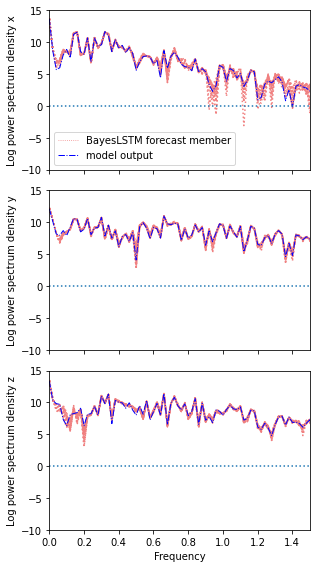

In [15]:
    ###################################################################################
    ###########       Logarithmic Power spectrum of testing data - full timeseries      ###########
    ###################################################################################  
    fig11 = plt.figure()
    fig11, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig11.set_size_inches(4.5, 8, forward=True)

    # forecast time series
    for j in range(step_lead_display):
        if j == 0: # for the legend
            ax1.plot(freqs_re[num_steps//2:], np.log(ps_pred[0, num_steps//2:,j]), color='lightcoral',
                     linestyle='dotted', linewidth=0.8, label='BayesLSTM forecast member')
            ax2.plot(freqs_re[num_steps//2:], np.log(ps_pred[1, num_steps//2:,j]), color='lightcoral',
                     linestyle='dotted', linewidth=0.8, label='BayesLSTM forecast member')
            ax3.plot(freqs_re[num_steps//2:], np.log(ps_pred[2, num_steps//2:,j]), color='lightcoral',
                     linestyle='dotted', linewidth=0.8, label='BayesLSTM forecast member')    
        else: 
            ax1.plot(freqs_re[num_steps//2:], np.log(ps_pred[0, num_steps//2:,j]), color='lightcoral', linestyle='dotted')
            ax2.plot(freqs_re[num_steps//2:], np.log(ps_pred[1, num_steps//2:,j]), color='lightcoral', linestyle='dotted')
            ax3.plot(freqs_re[num_steps//2:], np.log(ps_pred[2, num_steps//2:,j]), color='lightcoral', linestyle='dotted')
                
    # without perturbation
    ax1.plot(freqs_re[num_steps//2:], np.log(ps_obs_trivial_AR[0, num_steps//2:]), color='blue', linestyle='dashdot',
             linewidth=1.0, label='model output')
    ax2.plot(freqs_re[num_steps//2:], np.log(ps_obs_trivial_AR[1, num_steps//2:]), color='blue', linestyle='dashdot', linewidth=1.0)             
    ax3.plot(freqs_re[num_steps//2:], np.log(ps_obs_trivial_AR[2, num_steps//2:]), color='blue', linestyle='dashdot', linewidth=1.0)

    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-10, 15)
    ax2.set_ylim(-10, 15)
    ax3.set_ylim(-10, 15)

    ax1.set_xlim(0, 1.5)
    ax2.set_xlim(0, 1.5)
    ax3.set_xlim(0, 1.5)
    
    ax1.legend(frameon=True, loc=0, prop={'size': 10})
    #ax2.legend(frameon=True, loc=0, prop={'size': 8})
    #ax3.legend(frameon=True, loc=0, prop={'size': 8})
    
    ax1.set_ylabel("Log power spectrum density x", fontsize=10)
    ax2.set_ylabel("Log power spectrum density y", fontsize=10)
    ax3.set_ylabel("Log power spectrum density z", fontsize=10)
    
    plt.xlabel("Frequency", fontsize=10)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    fig11.savefig(os.path.join(output_path,'BayesLSTM_forecast_lorenz84_spectrum_log_onlyOne_leadTime{}.png'.format(step_lead_display)),dpi=150)

In [16]:
    #######################################################################################################
    #######   Compute power spectrum of testing data - full series of median adding shuffled error  #######
    #######################################################################################################
    # number of ensembles
    step_lead_display = 18
    predictand_median_error_full = np.zeros((3, num_steps, step_lead_display), dtype=float) # create full time series for the predictand
    
    for n in range(step_lead_display):
        predictand_median_error_full[0,:-test_len+n,n] = x[:-test_len+n]
        predictand_median_error_full[1,:-test_len+n,n] = y[:-test_len+n]
        predictand_median_error_full[2,:-test_len+n,n] = z[:-test_len+n]
        
        if n == 0:
            predictand_median_error_full[0,-test_len+n:,n] = predictand_median[0,:,n] * (x_max - x_min) + x_min + predictand_median_error[0,:,n]
            predictand_median_error_full[1,-test_len+n:,n] = predictand_median[1,:,n] * (y_max - y_min) + y_min + predictand_median_error[1,:,n]
            predictand_median_error_full[2,-test_len+n:,n] = predictand_median[2,:,n] * (z_max - z_min) + z_min + predictand_median_error[2,:,n]
        else:
            predictand_median_error_full[0,-test_len+n:,n] = predictand_median[0,:-n,n] * (x_max - x_min) + x_min + predictand_median_error[0,:-n,n]
            predictand_median_error_full[1,-test_len+n:,n] = predictand_median[1,:-n,n] * (y_max - y_min) + y_min + predictand_median_error[1,:-n,n]
            predictand_median_error_full[2,-test_len+n:,n] = predictand_median[2,:-n,n] * (z_max - z_min) + z_min + predictand_median_error[2,:-n,n]
    
    # FFT
    ps_pred_median_error = np.zeros(predictand_median_error_full.shape, dtype=float)
    ps_obs_trivial_AR = np.zeros((3, num_steps), dtype=float) # trivial low frequency signals originates from AR
    
    # calculate the frequency
    freqs = np.fft.fftfreq(num_steps, dt)
    # sort the index by frequency
    idx = np.argsort(freqs)
    # re-arrange frequency after sorting
    freqs_re = freqs[idx]
    
    # FFT of forecast
    for j in range(step_lead_display):
        ps_x_pred_median_error = np.abs(np.fft.fft(predictand_median_error_full[0,:,j])) ** 2
        ps_y_pred_median_error = np.abs(np.fft.fft(predictand_median_error_full[1,:,j])) ** 2
        ps_z_pred_median_error = np.abs(np.fft.fft(predictand_median_error_full[2,:,j])) ** 2
        
        # save fft results and sort them by frequency    
        ps_pred_median_error[0,:,j] = ps_x_pred_median_error[idx]
        ps_pred_median_error[1,:,j] = ps_y_pred_median_error[idx]
        ps_pred_median_error[2,:,j] = ps_z_pred_median_error[idx]
            
    # FFT of model output
    ps_x_AR = np.abs(np.fft.fft(x)) ** 2
    ps_y_AR = np.abs(np.fft.fft(y)) ** 2
    ps_z_AR = np.abs(np.fft.fft(z)) ** 2
    
    ps_obs_trivial_AR[0,:] = ps_x_AR[idx]
    ps_obs_trivial_AR[1,:] = ps_y_AR[idx]
    ps_obs_trivial_AR[2,:] = ps_z_AR[idx]

<Figure size 432x288 with 0 Axes>

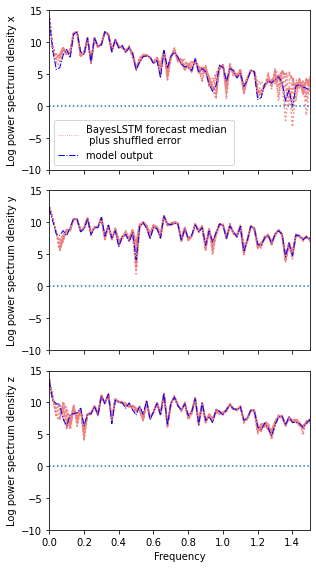

In [17]:
    ###################################################################################
    ###########       Logarithmic Power spectrum of testing data - full timeseries      ###########
    ###################################################################################  
    fig12 = plt.figure()
    fig12, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig12.set_size_inches(4.5, 8, forward=True)

    # forecast time series
    for j in range(step_lead_display):
        if j == 0: # for the legend
            ax1.plot(freqs_re[num_steps//2:], np.log(ps_pred_median_error[0, num_steps//2:,j]), color='lightcoral',
                     linestyle='dotted', linewidth=0.8, label='BayesLSTM forecast median \n plus shuffled error')
            ax2.plot(freqs_re[num_steps//2:], np.log(ps_pred_median_error[1, num_steps//2:,j]), color='lightcoral',
                     linestyle='dotted', linewidth=0.8, label='BayesLSTM forecast median \n plus shuffled error')
            ax3.plot(freqs_re[num_steps//2:], np.log(ps_pred_median_error[2, num_steps//2:,j]), color='lightcoral',
                     linestyle='dotted', linewidth=0.8, label='BayesLSTM forecast median \n plus shuffled error')    
        else: 
            ax1.plot(freqs_re[num_steps//2:], np.log(ps_pred_median_error[0, num_steps//2:,j]), color='lightcoral', linestyle='dotted')
            ax2.plot(freqs_re[num_steps//2:], np.log(ps_pred_median_error[1, num_steps//2:,j]), color='lightcoral', linestyle='dotted')
            ax3.plot(freqs_re[num_steps//2:], np.log(ps_pred_median_error[2, num_steps//2:,j]), color='lightcoral', linestyle='dotted')
                
    # without perturbation
    ax1.plot(freqs_re[num_steps//2:], np.log(ps_obs_trivial_AR[0, num_steps//2:]), color='blue', linestyle='dashdot',
             linewidth=1.0, label='model output')
    ax2.plot(freqs_re[num_steps//2:], np.log(ps_obs_trivial_AR[1, num_steps//2:]), color='blue', linestyle='dashdot', linewidth=1.0)             
    ax3.plot(freqs_re[num_steps//2:], np.log(ps_obs_trivial_AR[2, num_steps//2:]), color='blue', linestyle='dashdot', linewidth=1.0)

    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-10, 15)
    ax2.set_ylim(-10, 15)
    ax3.set_ylim(-10, 15)

    ax1.set_xlim(0, 1.5)
    ax2.set_xlim(0, 1.5)
    ax3.set_xlim(0, 1.5)
    
    ax1.legend(frameon=True, loc=0, prop={'size': 10})
    #ax2.legend(frameon=True, loc=0, prop={'size': 8})
    #ax3.legend(frameon=True, loc=0, prop={'size': 8})
    
    ax1.set_ylabel("Log power spectrum density x", fontsize=10)
    ax2.set_ylabel("Log power spectrum density y", fontsize=10)
    ax3.set_ylabel("Log power spectrum density z", fontsize=10)
    
    plt.xlabel("Frequency", fontsize=10)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    fig12.savefig(os.path.join(output_path,'BayesLSTM_forecast_lorenz84_shuffle_error_spectrum_log_onlyOne_leadTime{}.png'.format(step_lead_display)),dpi=150)

In [18]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # RMSE
    def RMSE(obs, pred):
        """
        Root Mean Square Error.
        """
        rmse = np.sqrt(np.mean((obs - pred)**2))
        
        return rmse
    
    # lead time dependent RMSE of Bayesian LSTM forecast
    rmse_bayes = np.zeros((step_lead+1, 3), dtype=float)
    rmse_bayes_median_error = np.zeros((step_lead+1, 3), dtype=float)
    rmse_persist = np.zeros((step_lead+1, 3), dtype=float)
    
    for i in range(step_lead):
        rmse_persist[i+1,0] = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], xx[-(test_len + step_lead)-1:-step_lead-1])
        rmse_persist[i+1,1] = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], yy[-(test_len + step_lead)-1:-step_lead-1])
        rmse_persist[i+1,2] = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], zz[-(test_len + step_lead)-1:-step_lead-1])        

        rmse_x_median_error = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_median[0,:,i] * (x_max - x_min) + x_min + predictand_median_error[0,:,i])
        rmse_y_median_error = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_median[1,:,i] * (y_max - y_min) + y_min + predictand_median_error[1,:,i])
        rmse_z_median_error = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_median[2,:,i] * (z_max - z_min) + z_min + predictand_median_error[2,:,i])
            
        rmse_x_bayes = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand[4,0,:,i] * (x_max - x_min) + x_min)
        rmse_y_bayes = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand[4,1,:,i] * (y_max - y_min) + y_min)
        rmse_z_bayes = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand[4,2,:,i] * (z_max - z_min) + z_min)
            
        rmse_bayes_median_error[i+1,0] = rmse_x_median_error
        rmse_bayes_median_error[i+1,1] = rmse_y_median_error
        rmse_bayes_median_error[i+1,2] = rmse_z_median_error
            
        rmse_bayes[i+1,0] = rmse_x_bayes
        rmse_bayes[i+1,1] = rmse_y_bayes
        rmse_bayes[i+1,2] = rmse_z_bayes

<Figure size 432x288 with 0 Axes>

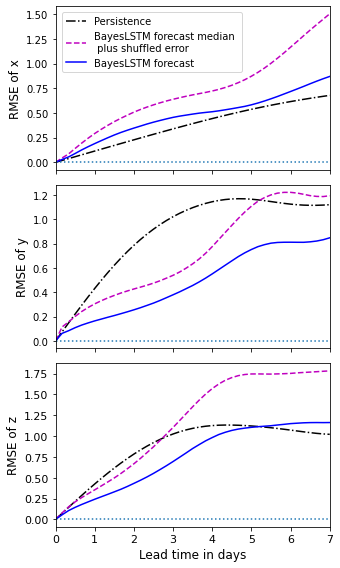

In [19]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################  
    display_upto = 42
        
    index = np.arange(0, step_lead)
    
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(4.8, 8, forward=True)
    
    # rmse of forecast
    ax1.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,0], color='k', linestyle='dashdot', label='Persistence')
    ax1.plot(np.arange(display_upto+1), rmse_bayes_median_error[:display_upto+1,0], color='m', linestyle='dashed', label='BayesLSTM forecast median \n plus shuffled error')
    ax1.plot(np.arange(display_upto+1), rmse_bayes[:display_upto+1,0], 'b', label='BayesLSTM forecast')
    
    ax2.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,1], color='k', linestyle='dashdot', label='Persistence')
    ax2.plot(np.arange(display_upto+1), rmse_bayes_median_error[:display_upto+1,1], color='m', linestyle='dashed', label='BayesLSTM forecast median \n plus shuffled error')
    ax2.plot(np.arange(display_upto+1), rmse_bayes[:display_upto+1,1], 'b', label='BayesLSTM forecast')
    
    ax3.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,2], color='k', linestyle='dashdot', label='Persistence')
    ax3.plot(np.arange(display_upto+1), rmse_bayes_median_error[:display_upto+1,2], color='m', linestyle='dashed', label='BayesLSTM forecast median \n plus shuffled error')
    ax3.plot(np.arange(display_upto+1), rmse_bayes[:display_upto+1,2], 'b', label='BayesLSTM forecast')    
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, display_upto)
    ax2.set_xlim(0, display_upto)
    ax3.set_xlim(0, display_upto)
    
    ax1.set_xticks(np.arange(0,display_upto+1,3))
    ax2.set_xticks(np.arange(0,display_upto+1,3))
    ax3.set_xticks(np.arange(0,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x", fontsize=12)
    ax2.set_ylabel("RMSE of y", fontsize=12)
    ax3.set_ylabel("RMSE of z", fontsize=12)
    
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1),fontsize=11)
    plt.yticks(fontsize=11)    
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.005,0.995), prop={'size': 10.0}, loc=2)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.995,0.03), prop={'size': 10.0}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig04.savefig(os.path.join(output_path,'rmse_bayes_forecast_median_error.png'),dpi=150)

In [20]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Euclidean distance
    def Euclidean(obs, pred):
        """
        Measure the Euclidean distance.
        ----------------------
        param obs: observation time series with the shape [dim, series]
        param pred: reference time series with the shape [dim, series]        
        """
        euclidean = np.mean(np.sqrt(np.sum((obs-pred)**2,0)))
        
        return euclidean
    
    # lead time dependent Euclidean distance of Bayesian forecast
    euclidean_bayes = np.zeros((step_lead+1), dtype=float)
    euclidean_bayes_median_error_denorm = np.zeros((step_lead+1), dtype=float)
    euclidean_persist = np.zeros(step_lead+1, dtype=float)
    
    obs = np.zeros((3, num_steps_long), dtype=float)
    obs[0,:] = xx[:]
    obs[1,:] = yy[:]
    obs[2,:] = zz[:]
    
    predictand_bayes_denorm = np.zeros(predictand[4,:,:,:].shape, dtype=float)
    predictand_bayes_denorm[0,:,:] = predictand[4,0,:,:] * (x_max - x_min) + x_min
    predictand_bayes_denorm[1,:,:] = predictand[4,1,:,:] * (y_max - y_min) + y_min
    predictand_bayes_denorm[2,:,:] = predictand[4,2,:,:] * (z_max - z_min) + z_min
    
    predictand_bayes_median_error_denorm = np.zeros(predictand_median[:,:,:].shape, dtype=float)
    predictand_bayes_median_error_denorm[0,:,:] = predictand_median[0,:,:] * (x_max - x_min) + x_min + predictand_median_error[0,:,:]
    predictand_bayes_median_error_denorm[1,:,:] = predictand_median[1,:,:] * (y_max - y_min) + y_min + predictand_median_error[1,:,:]
    predictand_bayes_median_error_denorm[2,:,:] = predictand_median[2,:,:] * (z_max - z_min) + z_min + predictand_median_error[2,:,:]
    
    for i in range(step_lead):
        euclidean_persist[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], obs[:,-(test_len + step_lead)-1:-step_lead-1])
        euclidean_bayes_median_error_denorm[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_bayes_median_error_denorm[:,:,i])
        euclidean_bayes[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_bayes_denorm[:,:,i])

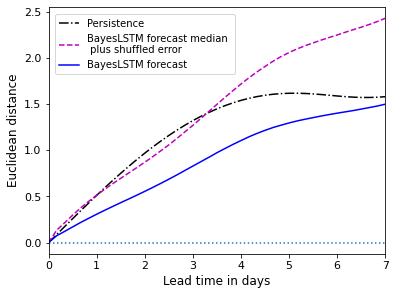

In [21]:
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    # zoom in
    display_upto = 42
    
    fig05 = plt.figure()
    fig05.set_size_inches(5.6, 4.2, forward=True)
    
    plt.plot(np.arange(display_upto+1), euclidean_persist[:display_upto+1], color='k', linestyle='dashdot', label='Persistence')
    plt.plot(np.arange(display_upto+1), euclidean_bayes_median_error_denorm[:display_upto+1], color='m', linestyle='dashed', label='BayesLSTM forecast median \n plus shuffled error')
    plt.plot(np.arange(display_upto+1), euclidean_bayes[:display_upto+1], color='b', label='BayesLSTM forecast')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, display_upto)
    plt.xticks(np.arange(0,display_upto+1,3),fontsize=11)
    

    plt.ylabel("Euclidean distance", fontsize=12)
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1),fontsize=11)
    plt.yticks(fontsize=11)
    
    plt.legend(frameon=True, prop={'size': 10.0}, bbox_to_anchor=(0.005,0.99), loc=2, ncol=1)
    #plt.legend(frameon=True, prop={'size': 8.0}, bbox_to_anchor=(0.99,0.005), loc=4, ncol=2)
    plt.tight_layout()

    plt.show()
    fig05.savefig(os.path.join(output_path,'euclidean_bayes_forecast_median_error.png'),dpi=150)